<a href="https://colab.research.google.com/github/vanhoanglong213/Tensorflow_187/blob/master/flowers_classification_with_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install tf-nightly-gpu
!pip install "tensorflow_hub == 0.4.0"
!pip install -U tensorflow_datasets

     |████████████████████████████████| 686kB 2.7MB/s 


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

tf.enable_eager_execution()

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [0]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [4]:
splits = tfds.Split.TRAIN.subsplit([70, 30])

(training_set, validation_set), dataset_info = tfds.load('tf_flowers', with_info=True, as_supervised=True, split=splits)

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/1.0.0. Subsequent calls will reuse this data.


In [5]:
num_classes = dataset_info.features['label'].num_classes

num_training_examples = 0
num_validation_examples = 0

for example in training_set:
  num_training_examples += 1
  
for example in validation_set:
  num_validation_examples += 1




print('Total Number of Classes: {}'.format(num_classes))

print('Total Number of Training Images: {}'.format(num_training_examples))

print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

Total Number of Classes: 5
Total Number of Training Images: 2590
Total Number of Validation Images: 1080 



In [6]:
for i, example in enumerate(training_set.take(5)):
  print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Image 1 shape: (240, 180, 3) label: 1
Image 2 shape: (177, 240, 3) label: 2
Image 3 shape: (375, 500, 3) label: 2
Image 4 shape: (331, 500, 3) label: 1
Image 5 shape: (333, 500, 3) label: 0


In [0]:
IMAGE_RES = 224

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return  image, label

BATCH_SIZE = 32

train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [0]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"

feature_extractor = hub.KerasLayer(URL,

                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

In [0]:
feature_extractor.trainable = False

In [12]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [13]:
model.compile(
  optimizer='adam', 
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

EPOCHS = 6

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
81/81 [==============================] - 14s 172ms/step - loss: 0.7986 - acc: 0.7069 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/6
81/81 [==============================] - 8s 102ms/step - loss: 0.3746 - acc: 0.8784 - val_loss: 0.3813 - val_acc: 0.8648
Epoch 3/6
81/81 [==============================] - 8s 101ms/step - loss: 0.2901 - acc: 0.9035 - val_loss: 0.3475 - val_acc: 0.8778
Epoch 4/6
81/81 [==============================] - 8s 101ms/step - loss: 0.2413 - acc: 0.9236 - val_loss: 0.3299 - val_acc: 0.8815
Epoch 5/6
81/81 [==============================] - 8s 102ms/step - loss: 0.2069 - acc: 0.9394 - val_loss: 0.3194 - val_acc: 0.8880
Epoch 6/6
81/81 [==============================] - 8s 101ms/step - loss: 0.1809 - acc: 0.9486 - val_loss: 0.3126 - val_acc: 0.8861


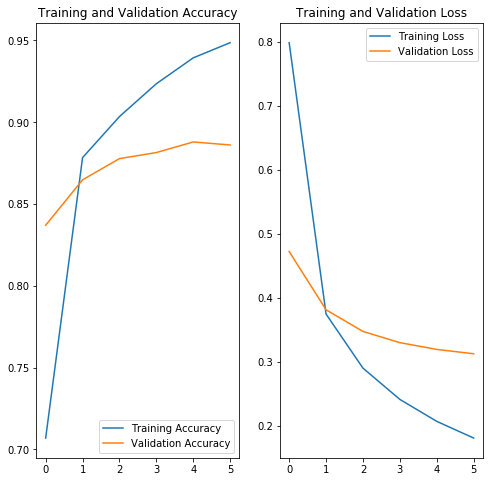

In [14]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [15]:
class_names = np.array(dataset_info.features['label'].names)

print(class_names)

['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


In [16]:
image_batch, label_batch = next(iter(train_batches))


image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]

print(predicted_class_names)

['roses' 'dandelion' 'tulips' 'daisy' 'tulips' 'daisy' 'dandelion' 'roses'
 'tulips' 'dandelion' 'daisy' 'dandelion' 'dandelion' 'roses' 'roses'
 'tulips' 'dandelion' 'sunflowers' 'daisy' 'tulips' 'dandelion' 'tulips'
 'daisy' 'tulips' 'dandelion' 'roses' 'tulips' 'dandelion' 'tulips'
 'tulips' 'daisy' 'daisy']


In [17]:
print("Labels: ", label_batch)

print("Predicted labels: ", predicted_ids)

Labels:  [4 0 2 1 2 1 0 4 2 3 1 0 0 4 4 2 4 3 1 2 0 2 1 4 0 4 2 0 2 2 1 1]
Predicted labels:  [4 0 2 1 2 1 0 4 2 0 1 0 0 4 4 2 0 3 1 2 0 2 1 2 0 4 2 0 2 2 1 1]


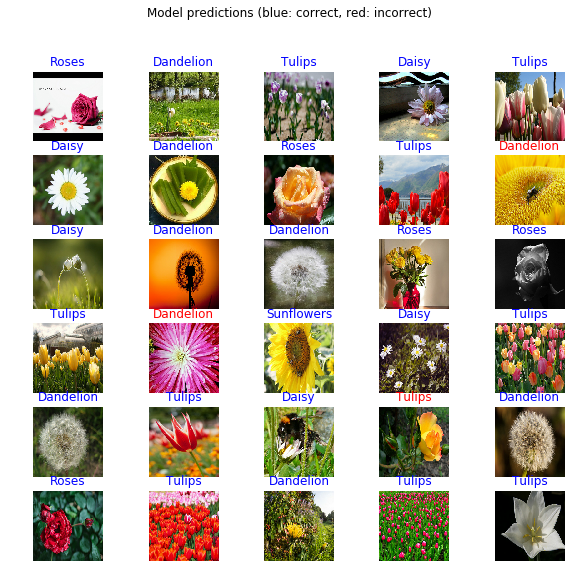

In [18]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")